#Import All Required Libraries

In [66]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("goyaladi/twitter-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-dataset


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


#Load Dataset

In [68]:
df = pd.read_csv(f'{path}/twitter_dataset.csv')
print(f"Dataset Loaded: {df.shape[0]} rows × {df.shape[1]} columns")

Dataset Loaded: 10000 rows × 6 columns


#Initial Data Exploration + Missing Value Check

In [69]:
df.head()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
0,1,julie81,Party least receive say or single. Prevent pre...,2,25,2023-01-30 11:00:51
1,2,richardhester,Hotel still Congress may member staff. Media d...,35,29,2023-01-02 22:45:58
2,3,williamsjoseph,Nice be her debate industry that year. Film wh...,51,25,2023-01-18 11:25:19
3,4,danielsmary,Laugh explain situation career occur serious. ...,37,18,2023-04-10 22:06:29
4,5,carlwarren,Involve sense former often approach government...,27,80,2023-01-24 07:12:21


In [70]:
df.tail()

,Tweet_ID,Username,Text,Retweets,Likes,Timestamp
9995,9996,ntate,Agree reflect military box ability ever hold. ...,81,86,2023-01-15 11:46:20
9996,9997,garrisonjoshua,Born which push still. Degree sometimes contro...,73,100,2023-05-06 00:46:54
9997,9998,adriennejackson,You day agent likely region. Teacher data mess...,10,62,2023-02-27 14:55:08
9998,9999,kcarlson,Guess without successful save. Particular natu...,21,60,2023-01-09 16:09:35
9999,10000,vdickerson,Body onto understand team about product beauti...,65,54,2023-04-19 01:35:56


In [71]:
# Info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   10000 non-null  int64 
 1   Username   10000 non-null  object
 2   Text       10000 non-null  object
 3   Retweets   10000 non-null  int64 
 4   Likes      10000 non-null  int64 
 5   Timestamp  10000 non-null  object
dtypes: int64(3), object(3)
memory usage: 468.9+ KB


In [72]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [73]:
df.duplicated().any()

np.False_

In [74]:
df.isna().any()

,0
Tweet_ID,False
Username,False
Text,False
Retweets,False
Likes,False
Timestamp,False


In [75]:
# Summary Stats

df.describe()

,Tweet_ID,Retweets,Likes,Timestamp
count,10000.00000,10000.000000,10000.000000,10000
mean,5000.50000,49.721200,49.929300,2023-03-08 19:55:00.845099776
min,1.00000,0.000000,0.000000,2023-01-01 00:01:15
25%,2500.75000,25.000000,25.000000,2023-02-02 18:35:42.500000
50%,5000.50000,49.000000,50.000000,2023-03-08 17:56:55.500000
75%,7500.25000,75.000000,75.000000,2023-04-11 09:22:33.750000128
max,10000.00000,100.000000,100.000000,2023-05-15 12:32:09
std,2886.89568,28.948856,28.877193,NaN


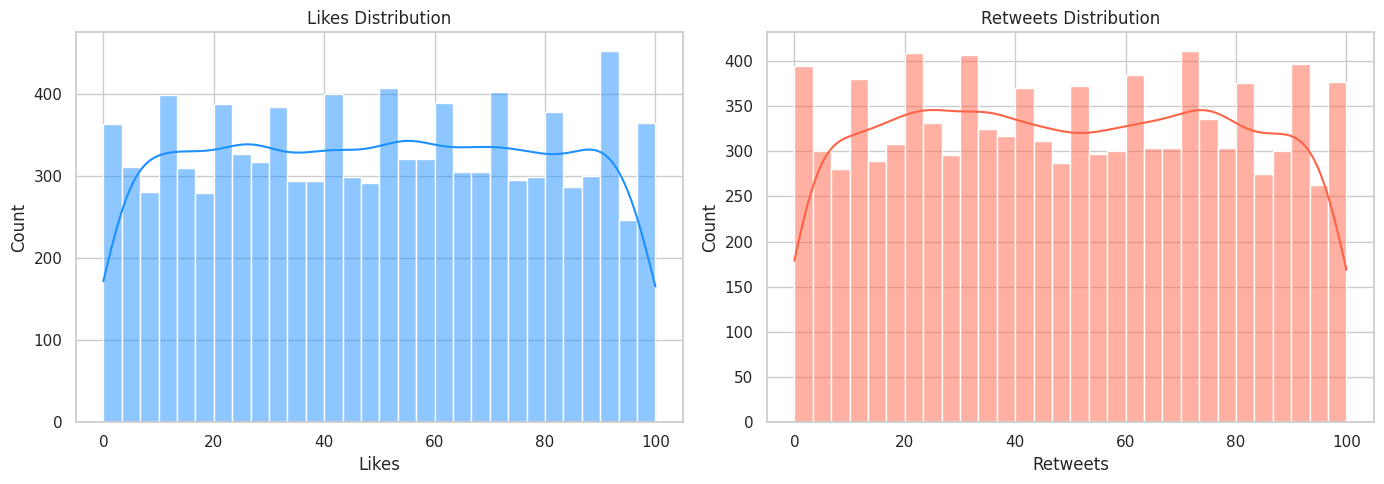

In [76]:
# Histograms of likes/retweets
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['Likes'], bins=30, kde=True, ax=axs[0], color='dodgerblue')
axs[0].set_title("Likes Distribution")

sns.histplot(df['Retweets'], bins=30, kde=True, ax=axs[1], color='tomato')
axs[1].set_title("Retweets Distribution")
plt.tight_layout()
plt.show()

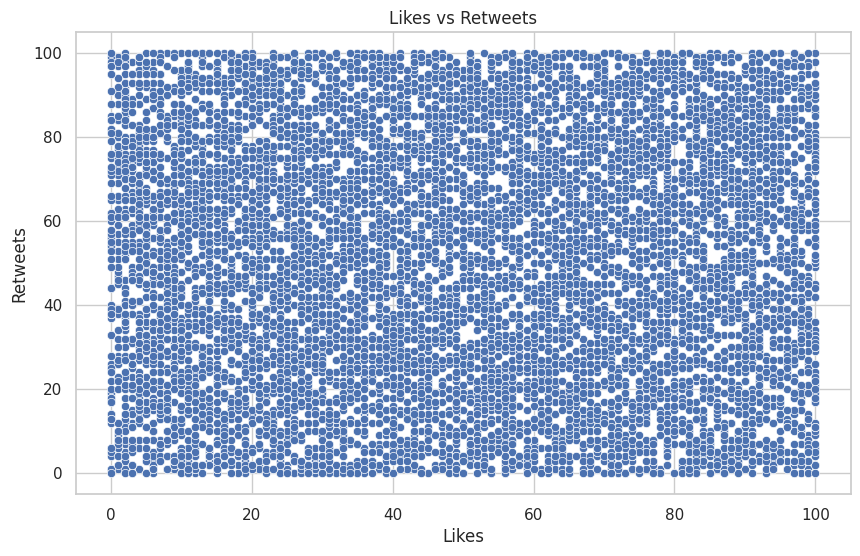

In [77]:
# Scatter: Likes vs Retweets
sns.scatterplot(x='Likes', y='Retweets', data=df)
plt.title("Likes vs Retweets")
plt.show()

Visual Explorations

#Cleaning and Justified Cleaning

In [78]:
# Drop irrelevant for clustering
df_cleaned = df.drop(columns=['Tweet_ID', 'Username', 'Text'])


#Feature Engineering

In [79]:
# Convert the 'Timestamp' column to datetime format


#  Extract useful time-related features

# Extract the hour of the tweet (e.g., 0 to 23)
df_cleaned['Hour'] = df_cleaned['Timestamp'].dt.hour

# Extract the day of the week (0 = Monday, 6 = Sunday)
df_cleaned['DayOfWeek'] = df_cleaned['Timestamp'].dt.dayofweek

# Drop 'Timestamp' after extracting what we need
# It’s a datetime object and not usable directly in clustering algorithms
df_cleaned.drop(columns='Timestamp', inplace=True)

# Create new engagement-related features

# Total engagement = Likes + Retweets
# This feature combines Likes and Retweets to measure the total interaction a tweet receives, helping to identify high- vs. low-engagement users
df_cleaned['Engagement_Score'] = df_cleaned['Likes'] + df_cleaned['Retweets']

# Ratio of likes to retweets (add 1 to avoid division by zero)
# This ratio reveals the type of engagement by comparing likes to retweets, indicating whether users tend to appreciate or amplify content
df_cleaned['Like_to_Retweet_Ratio'] = df_cleaned['Likes'] / (df_cleaned['Retweets'] + 1)

# Preview the DataFrame after feature engineering
print("Feature engineering completed. Sample data:")
print(df_cleaned[['Hour', 'DayOfWeek', 'Engagement_Score', 'Like_to_Retweet_Ratio']].head())

Feature engineering completed. Sample data:
   Hour  DayOfWeek  Engagement_Score  Like_to_Retweet_Ratio
0    11          0                27               8.333333
1    22          0                64               0.805556
2    11          2                76               0.480769
3    22          0                55               0.473684
4     7          1               107               2.857143


#Feature Scaling

In [80]:
# Step 1: Drop non-numeric columns (like 'Date') if present
# This ensures we only scale numeric features
df_numeric = df_cleaned.drop(columns='Date', errors='ignore')

# Step 2: Apply Z-score Standardization to scale numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(df_numeric)

# Step 3: Create a new DataFrame from the scaled data
scaled_df = pd.DataFrame(scaled, columns=df_numeric.columns)

# Step 4: Preview the result
print("Feature scaling complete. Here's a preview:")
print(scaled_df.head())

Feature scaling complete. Here's a preview:
   Retweets     Likes      Hour  DayOfWeek  Engagement_Score  \
0 -1.648548 -0.863330 -0.068365  -1.485533         -1.765591   
1 -0.508550 -0.724805  1.521851  -1.485533         -0.866397   
2  0.044177 -0.863330 -0.068365  -0.486688         -0.574767   
3 -0.439459 -1.105748  1.521851  -1.485533         -1.085120   
4 -0.784913  1.041382 -0.646625  -0.986110          0.178611   

   Like_to_Retweet_Ratio  
0               0.827466  
1              -0.252216  
2              -0.298799  
3              -0.299815  
4               0.042036  


#KMeans Clustering + Silhouette Score

In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform KMeans clustering (3 groups)
kmeans = KMeans(n_clusters=3, random_state=42)

# Use all numeric data directly from scaled_df
train_data = scaled_df.select_dtypes(include='number')

# Fit and predict clusters
clusters = kmeans.fit_predict(train_data)

# Assign cluster labels to DataFrame
scaled_df['Cluster'] = clusters

# Evaluate clustering quality
sil_score = silhouette_score(train_data, clusters)
print(f"KMeans clustering complete | Silhouette Score: {sil_score:.3f}")

KMeans clustering complete | Silhouette Score: 0.219


#Elbow Method (Visualize K Choice)

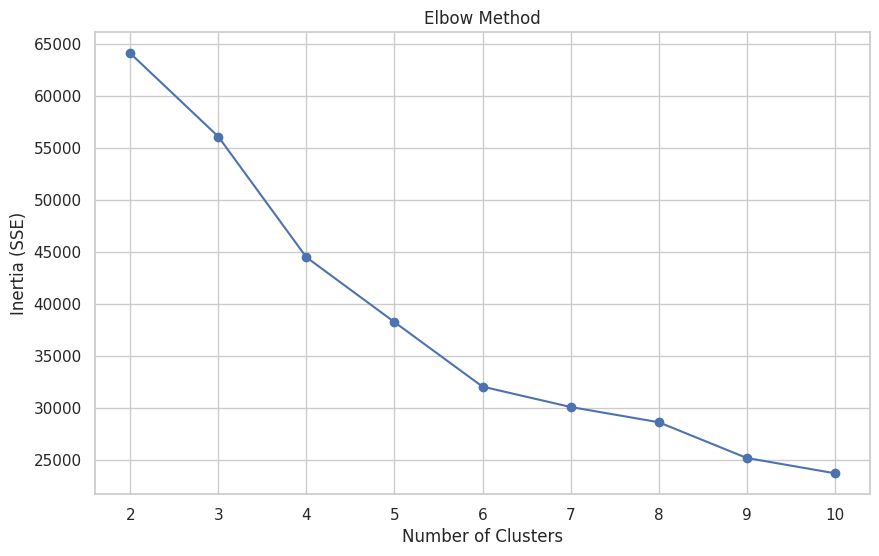

In [102]:
sse = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(train_data)
    sse.append(km.inertia_)

plt.plot(range(2, 11), sse, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)")
plt.grid(True)
plt.show()


In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform KMeans clustering (3 groups)
kmeans = KMeans(n_clusters=7, random_state=42)

# Use all numeric data directly from scaled_df
train_data = scaled_df.select_dtypes(include='number')

# Fit and predict clusters
clusters = kmeans.fit_predict(train_data)

# Assign cluster labels to DataFrame
scaled_df['Cluster'] = clusters

# Evaluate clustering quality
sil_score = silhouette_score(train_data, clusters)
print(f"KMeans clustering complete | Silhouette Score: {sil_score:.3f}")

KMeans clustering complete | Silhouette Score: 0.339


#PCA Visualization

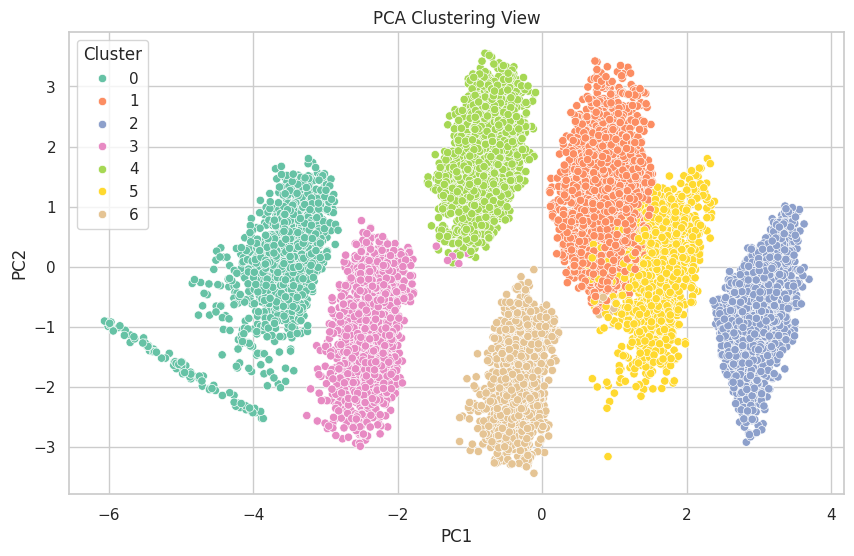

In [146]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2')
plt.title("PCA Clustering View")
plt.show()

#Final Cluster Summary

In [177]:
# Summary in standardized space
summary = scaled_df.groupby('Cluster').mean()
print("Cluster Summary (Standardized):\n")
summary



Cluster Summary (Standardized):



,Retweets,Likes,Hour,DayOfWeek,Engagement_Score,Like_to_Retweet_Ratio
Cluster,,,,,,
0,-1.149465,0.854286,-0.111023,-0.628145,-0.209145,1.353326
1,0.846957,0.385807,-0.061517,-1.005869,0.866572,-0.241266
2,0.494585,-0.874497,0.458322,0.680934,-0.265743,-0.303399
3,-0.641062,-0.794445,-1.016594,-0.134516,-1.008489,-0.136827
4,0.929837,0.712512,-0.435520,0.754491,1.154144,-0.229102
5,-0.689076,0.900580,0.577359,0.858869,0.147223,0.165130
6,-0.886142,-0.960285,0.718684,-0.469721,-1.297281,-0.106597


In [178]:
# Restore original scale
restored = scaler.inverse_transform(scaled_df.drop(columns='Cluster'))
original_df = pd.DataFrame(restored, columns=df_cleaned.columns)
original_df['Cluster'] = scaled_df['Cluster']

original_df.groupby('Cluster').mean()



,Retweets,Likes,Hour,DayOfWeek,Engagement_Score,Like_to_Retweet_Ratio
Cluster,,,,,,
0,16.447177,74.597450,10.704918,1.716758,91.044627,11.999744
1,74.238417,61.069755,11.047371,0.960437,135.308173,0.881902
2,64.038164,24.677544,14.643252,4.337942,88.715708,0.448700
3,31.164125,26.989107,4.440813,2.705156,58.153232,1.610070
4,76.637557,70.503611,8.460276,4.485227,147.141169,0.966710
5,29.774222,75.934222,15.466667,4.694222,105.708444,3.715381
6,24.069686,22.200348,16.444251,2.033972,46.270035,1.820841


In [180]:


# 1. Create a dictionary to map cluster numbers to descriptive names
cluster_names = {
    0: "The Appreciators",
    1: "Early-Week Amplifiers",
    2: "Late-Week Retweeters",
    3: "Early Morning Minimalists",
    4: "Power Users",
    5: "Weekend Socializers",
    6: "Low-Activity Users"
}

# 2. Create a new 'Cluster_Name' column by mapping the 'Cluster' column
original_df['Cluster_Name'] = original_df['Cluster'].map(cluster_names)

# 3. Display the first few rows of the DataFrame with the new column
print("DataFrame with Cluster Names:\n")
original_df.head()



DataFrame with Cluster Names:



,Retweets,Likes,Hour,DayOfWeek,Engagement_Score,Like_to_Retweet_Ratio,Cluster,Cluster_Name
0,2.0,25.0,11.0,0.0,27.0,8.333333,6,Low-Activity Users
1,35.0,29.0,22.0,0.0,64.0,0.805556,6,Low-Activity Users
2,51.0,25.0,11.0,2.0,76.0,0.480769,3,Early Morning Minimalists
3,37.0,18.0,22.0,0.0,55.0,0.473684,6,Low-Activity Users
4,27.0,80.0,7.0,1.0,107.0,2.857143,0,The Appreciators


In [181]:

print("\nNumber of users in each cluster:\n")
original_df['Cluster_Name'].value_counts()


Number of users in each cluster:



,count
Cluster_Name,
Early-Week Amplifiers,1921
Late-Week Retweeters,1808
Power Users,1523
Early Morning Minimalists,1377
Low-Activity Users,1148
Weekend Socializers,1125
The Appreciators,1098


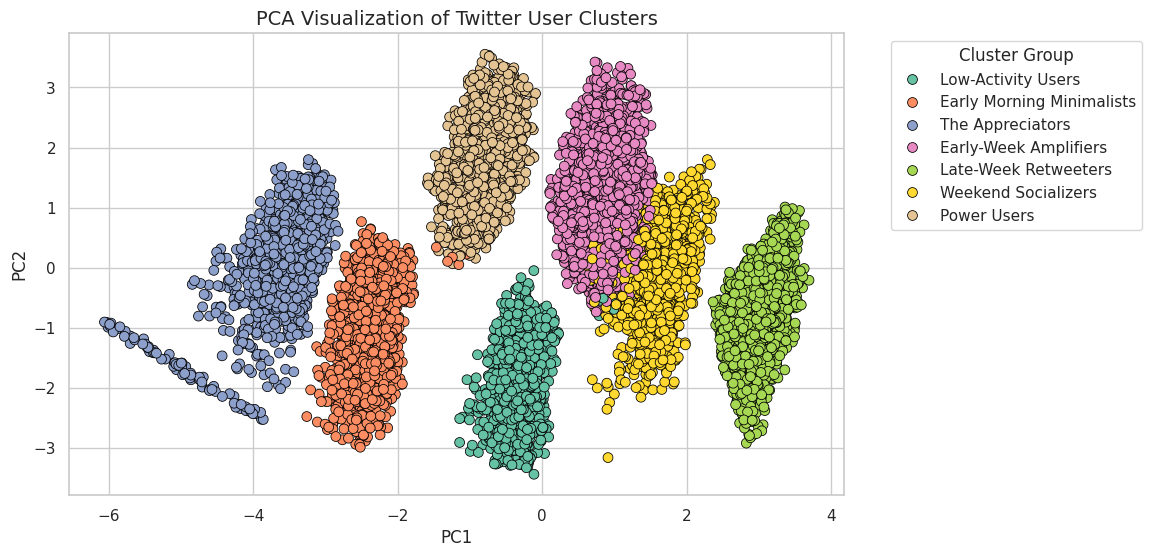

In [185]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = original_df['Cluster']
pca_df['Cluster_Name'] = original_df['Cluster_Name']

sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Name', data=pca_df, palette='Set2',s=50,edgecolor='black')

plt.title("PCA Visualization of Twitter User Clusters", fontsize=14)
plt.legend(title='Cluster Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#  **Interpretation of Clusters**

### **Group 0: The "Appreciators"**
**Explanation:**  
This group shows appreciation for content much more than they share it, characterized by a very high number of likes but low retweets. They are most active in the late morning, around Tuesday and Wednesday.

---

### **Group 1: "Early-Week Amplifiers"**
**Explanation:**  
These users have high engagement, especially in the form of retweets. Their activity is concentrated at the beginning of the week (Monday/Tuesday).

---

### **Group 2: "Late-Week Retweeters"**
**Explanation:**  
This group has a strong preference for retweeting content over liking it and is most active towards the end of the week (Friday) in the afternoon.

---

### **Group 3: "Early Morning Minimalists"**
**Explanation:**  
A low-engagement group with minimal likes or retweets. Their unique characteristic is their activity in the very early morning hours (around 4–5 AM).

---

### **Group 4: The "Power Users"**
**Explanation:**  
This is your most engaged group with the highest overall engagement score. They have a high number of both retweets and likes and are most active towards the end of the week.

---

### **Group 5: "Weekend Socializers"**
**Explanation:**  
This group has a strong preference for liking content over retweeting. They are most active later in the week (Friday/Saturday) and in the afternoon, suggesting more casual use of the platform.

---

### **Group 6: "Low-Activity Users"**
**Explanation:**  
This is the least engaged group, with very low numbers of both likes and retweets. They are slightly more active in the late afternoon but with minimal interaction.
